In [159]:
import pandas as pd

# Predicting CCS values of peptides with unknown modality

## Load best model

In [160]:
## Load best model
import sys
from datetime import datetime
sys.path.append('/home/robbe/IM2DeepMulti')
sys.path.append('/home/robbe/IM2DeepMulti/IM2DeepMulti')

In [161]:
config = {
    "name": "BestValPerformanceBestModel",
    "time": datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
    "batch_size": 32,
    "learning_rate": 0.0000885185503354955,
    "diversity_weight": 1.2631492541307987,    # Should be high when using FlexibleLoss (4.2), much lower when using FlexibleLossSorted (1)
    "L1_alpha": 0.00000043707211872154, #0.00003 for FlexibleLoss, 0.02 for FlexibleLossSorted
    "epochs": 300,
    "delta": 0,
    "device": "1",
    "Use_best_model": True,
    "Add_branch_layer": False,
    'BranchSize': 28, #64 seems to be the best
    'Loss_type': 'FlexibleLossSorted',
    'Use_attention_output': True,
    'Use_attention_concat': True,
}

In [162]:
import torch
checkpoint = torch.load('/home/robbe/IM2DeepMulti/checkpoints/BestPearsonBestModel-2024-04-08_09-33-13.ckpt')

In [163]:
from IM2DeepMulti.models import IM2DeepMultiTransferWithAttention
import IM2DeepMulti.utils
criterion = IM2DeepMulti.utils.FlexibleLossSorted(config['diversity_weight'])
best_model = IM2DeepMultiTransferWithAttention.load_from_checkpoint('/home/robbe/IM2DeepMulti/checkpoints/BestPearsonBestModel-2024-04-08_09-33-13.ckpt', config=config, criterion=criterion)

1335
480
20
6
1841


## Prepare data

In [164]:
import pickle
import numpy as np
ccs_df = pickle.load(open('/home/robbe/IM2DeepMulti/data/ccs_df_EvaluationV2.pkl', 'rb'))
AtomEnc = pickle.load(open('/home/robbe/IM2DeepMulti/data/AtomEnc-EvaluationV2.pickle', 'rb'))
Globals = pickle.load(open('/home/robbe/IM2DeepMulti/data/GlobalFeatures-EvaluationV2.pickle', 'rb'))
DiAminoAtomEnc = pickle.load(open('/home/robbe/IM2DeepMulti/data/DiAminoAtomEnc-EvaluationV2.pickle', 'rb'))
OneHot = pickle.load(open('/home/robbe/IM2DeepMulti/data/OneHot-EvaluationV2.pickle', 'rb'))
y = pickle.load(open('/home/robbe/IM2DeepMulti/data/y_EvaluationV2.pickle', 'rb'))
y = np.vstack(y)

AtomEnc = torch.tensor(AtomEnc, dtype=torch.float32).to(torch.device('cuda'))
Globals = torch.tensor(Globals, dtype=torch.float32).to(torch.device('cuda'))
DiAminoAtomEnc = torch.tensor(DiAminoAtomEnc, dtype=torch.float32).to(torch.device('cuda'))
OneHot = torch.tensor(OneHot, dtype=torch.float32).to(torch.device('cuda'))
y = torch.tensor(y, dtype=torch.float32).to(torch.device('cuda'))
dataset = torch.utils.data.TensorDataset(AtomEnc, DiAminoAtomEnc, Globals, OneHot, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], shuffle=False)

# Predict

In [165]:
# Make predictions
best_model.eval()
with torch.no_grad():
    predictions = []
    for batch in dataloader:
        prediction = best_model.predict_step(batch)
        predictions.append(prediction)
    predictions = torch.cat(predictions, dim=0)

In [166]:
# Add predictions to ccs_df in two separate columns
ccs_df['Predicted CCS 1'] = predictions[:, 0].cpu().numpy()
ccs_df['Predicted CCS 2'] = predictions[:, 1].cpu().numpy()

In [167]:
ccs_df

,Modified sequence,Intensity,charge,m/z,Retention time,Raw file,Experiment,1/K0,CCS,between_brackets,seq,modifications,tr,Predicted CCS 1,Predicted CCS 2
0,(ac)AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,44101.0,3,1121.204960,18.102,12_S1-B12_1_7060,C4,1.148689,692.93933,Acetyl (Protein N-term,AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,0|Acetyl,0,694.902161,673.718811
1,(ac)AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,108470.0,3,1121.204960,18.162,7_S1-B2_1_7050,B3,1.148689,692.93933,Acetyl (Protein N-term,AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,0|Acetyl,0,694.902161,673.718811
2,(ac)AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,81176.0,3,1121.204960,18.120,8_S1-B4_1_7052,B4,1.143574,689.85360,Acetyl (Protein N-term,AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,0|Acetyl,0,694.902161,673.718811
3,(ac)AAAAAGPGAWAAQEK,12718.0,2,706.351865,24.833,4_S1-A8_1_7044,A4,1.087225,439.72745,Acetyl (Protein N-term,AAAAAGPGAWAAQEK,0|Acetyl,0,439.935181,413.782288
4,(ac)AAAAAMAEQEGAR,37584.0,2,644.801151,23.007,7_S1-B2_1_7050,B3,0.984387,398.50415,Acetyl (Protein N-term,AAAAAMAEQEGAR,0|Acetyl,0,397.589111,371.591156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48262,YYTSASGDEM(ox)VSLKDYCTR,387300.0,3,754.661159,18.328,4_S1-A8_1_7044,A4,0.989541,598.13030,Oxidation (M,YYTSASGDEMVSLKDYCTR,10|Oxidation|17|Carbamidomethyl,0,608.455383,567.058167
48263,YYTSASGDEM(ox)VSLKDYCTR,214360.0,3,754.661159,18.409,5_S1-A10_1_7046,B1,0.992117,599.68760,Oxidation (M,YYTSASGDEMVSLKDYCTR,10|Oxidation|17|Carbamidomethyl,0,608.455383,567.058167
48264,YYTSASGDEM(ox)VSLKDYCTR,265250.0,3,754.661159,18.409,6_S1-A12_1_7048,B2,0.989541,598.13030,Oxidation (M,YYTSASGDEMVSLKDYCTR,10|Oxidation|17|Carbamidomethyl,0,608.455383,567.058167
48265,YYTSASGDEM(ox)VSLKDYCTR,468150.0,3,754.661159,18.487,8_S1-B4_1_7052,B4,0.992117,599.68760,Oxidation (M,YYTSASGDEMVSLKDYCTR,10|Oxidation|17|Carbamidomethyl,0,608.455383,567.058167


## Align the predictions back to the observed CCS range

In [168]:
# Calculate shifts per charge and instead of adding charge to PXD data, add shift to predictions
Evaluation_dataset_with_overlap = pd.read_csv('/home/robbe/IM2DeepMulti/dataset/Evaluation_dataset_with_overlap_v2.csv')
traindata = pd.read_csv('/home/robbe/IM2DeepMulti/dataset/final_conformers_filtered.csv')
traindata.head()


,Modified sequence,Charge,Accession,Conformer id,CCS,Intensity,Conformer id total
0,_YRPGTVALR_,2,PXD043226,2.0,368.427155,4.730200e+07,1.0
1,_YRPGTVALR_,2,PXD036191,1.0,364.510139,4.055425e+07,1.0
2,_YPIEHGIITNWDDMEK_,3,PXD036191,2.0,545.583121,3.716250e+07,1.0
3,_RYDDPEVQK_,2,PXD019086,2.0,382.515895,2.952900e+07,1.0
4,_VTIAQGGVLPNIQAVLLPK_,2,PXD040521,2.0,509.465589,2.778083e+07,1.0


In [169]:
traindata_highest_intensity = traindata.groupby(['Modified sequence', 'Charge'], as_index=False).apply(lambda x: x.loc[x['Intensity'].idxmax()])

In [170]:
traindata_highest_intensity

,Modified sequence,Charge,Accession,Conformer id,CCS,Intensity,Conformer id total
0,_(Acetyl (Protein N-term))AAAAAAAAAAGAAGGR_,2,PXD036191,1.0,421.790696,6.456625e+05,1.0
1,_(Acetyl (Protein N-term))AAAAAAAAAAGDSDSWDADT...,3,PXD037622,1.0,682.415049,3.194958e+05,1.0
2,_(Acetyl (Protein N-term))AAAAAAAAEQQSSNGPVKK_,2,PXD036127,1.0,492.624681,4.631908e+04,1.0
3,_(Acetyl (Protein N-term))AAAAAAAGDSDSWDADAFSV...,2,PXD019086,1.0,578.648246,1.257952e+06,1.0
4,_(Acetyl (Protein N-term))AAAAAAAGDSDSWDADAFSV...,2,PXD036127,1.0,560.411181,1.651172e+05,1.0
...,...,...,...,...,...,...,...
168595,_YYYHYDLLR_,2,PXD042114,1.0,401.861014,1.503200e+04,1.0
168596,_YYYQGCASWK_,2,PXD036191,1.0,396.843602,1.937867e+05,1.0
168597,_YYYVCQYCPAGNWANR_,2,PXD019086,1.0,471.328520,8.426100e+04,1.0
168598,_YYYVPADFVEYEK_,2,PXD019086,1.0,450.259491,3.828100e+05,1.0


In [171]:
def align(Evaluation_dataset_with_overlap, traindata, ccs_df):
    for i, run in enumerate(Evaluation_dataset_with_overlap['Raw file'].unique()):
        shift_dict = {}
        data_run = Evaluation_dataset_with_overlap[Evaluation_dataset_with_overlap['Raw file'] == run]

        try:
            merged = pd.merge(data_run, traindata, on=['Modified sequence', 'Charge'], how='inner', suffixes=('_data', '_train'))
            shift_dict = merged.groupby('Charge').apply(lambda x: x['CCS_train'].mean() - x['CCS_data'].mean()).to_dict() #How much train data is bigger, so we need to decrease the predictions by these amounts
            print('Shifts for run', run, shift_dict)
            for charge, shift in shift_dict.items():
                ccs_df.loc[(ccs_df['Raw file'] == run) & (ccs_df['charge'] == charge), 'Predicted CCS 1'] -= shift
                ccs_df.loc[(ccs_df['Raw file'] == run) & (ccs_df['charge'] == charge), 'Predicted CCS 2'] -= shift
        except Exception as e:
            print('No overlap found for run', run, e)
            continue
    return ccs_df




In [172]:
ccs_df_aligned = align(Evaluation_dataset_with_overlap, traindata_highest_intensity, ccs_df)

Shifts for run 7_S1-B2_1_7050 {2: 1.04781884898091, 3: -2.280390125931035, 4: 9.263762297948347}
Shifts for run 8_S1-B4_1_7052 {2: 1.039570825826388, 3: -2.7570495788068, 4: 7.628661245579565}
Shifts for run 10_S1-B8_1_7056 {2: -0.20169895620989564, 3: -3.478919949988608, 4: 4.135979147856801}
Shifts for run 11_S1-B10_1_7058 {2: 1.7901351136312087, 3: -0.5677155591281462, 4: 10.37947225078483}
Shifts for run 13_S1-C2_1_7062 {2: 1.5683317215787156, 3: -0.4178744781003161, 4: 7.982929910693429}
Shifts for run 14_S1-C4_1_7064 {2: 1.7925865379667698, 3: -0.5235367595315665, 4: 9.302570846207004}
Shifts for run 15_S1-C6_1_7066 {2: 2.3798096229232897, 3: 0.3899451843586803, 4: 9.783171514782453}
Shifts for run 16_S1-C8_1_7068 {2: 1.5602307836155092, 3: -1.7118445200544556, 4: 7.219675698172068}
Shifts for run 1_S1-A2_1_7038 {2: 2.0605733476887167, 3: -1.0084593694998603, 4: 4.878739452178706}
Shifts for run 2_S1-A4_1_7040 {2: 0.6822124512648884, 3: -2.51388165852552, 4: 6.769570424913923}
Sh

In [173]:
ccs_df

,Modified sequence,Intensity,charge,m/z,Retention time,Raw file,Experiment,1/K0,CCS,between_brackets,seq,modifications,tr,Predicted CCS 1,Predicted CCS 2
0,(ac)AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,44101.0,3,1121.204960,18.102,12_S1-B12_1_7060,C4,1.148689,692.93933,Acetyl (Protein N-term,AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,0|Acetyl,0,696.946350,675.763000
1,(ac)AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,108470.0,3,1121.204960,18.162,7_S1-B2_1_7050,B3,1.148689,692.93933,Acetyl (Protein N-term,AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,0|Acetyl,0,697.182556,675.999207
2,(ac)AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,81176.0,3,1121.204960,18.120,8_S1-B4_1_7052,B4,1.143574,689.85360,Acetyl (Protein N-term,AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,0|Acetyl,0,697.659180,676.475830
3,(ac)AAAAAGPGAWAAQEK,12718.0,2,706.351865,24.833,4_S1-A8_1_7044,A4,1.087225,439.72745,Acetyl (Protein N-term,AAAAAGPGAWAAQEK,0|Acetyl,0,438.160431,412.007538
4,(ac)AAAAAMAEQEGAR,37584.0,2,644.801151,23.007,7_S1-B2_1_7050,B3,0.984387,398.50415,Acetyl (Protein N-term,AAAAAMAEQEGAR,0|Acetyl,0,396.541290,370.543335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48262,YYTSASGDEM(ox)VSLKDYCTR,387300.0,3,754.661159,18.328,4_S1-A8_1_7044,A4,0.989541,598.13030,Oxidation (M,YYTSASGDEMVSLKDYCTR,10|Oxidation|17|Carbamidomethyl,0,609.239868,567.842651
48263,YYTSASGDEM(ox)VSLKDYCTR,214360.0,3,754.661159,18.409,5_S1-A10_1_7046,B1,0.992117,599.68760,Oxidation (M,YYTSASGDEMVSLKDYCTR,10|Oxidation|17|Carbamidomethyl,0,609.720215,568.322998
48264,YYTSASGDEM(ox)VSLKDYCTR,265250.0,3,754.661159,18.409,6_S1-A12_1_7048,B2,0.989541,598.13030,Oxidation (M,YYTSASGDEMVSLKDYCTR,10|Oxidation|17|Carbamidomethyl,0,609.418823,568.021606
48265,YYTSASGDEM(ox)VSLKDYCTR,468150.0,3,754.661159,18.487,8_S1-B4_1_7052,B4,0.992117,599.68760,Oxidation (M,YYTSASGDEMVSLKDYCTR,10|Oxidation|17|Carbamidomethyl,0,611.212402,569.815186


In [174]:
ccs_df_aligned

,Modified sequence,Intensity,charge,m/z,Retention time,Raw file,Experiment,1/K0,CCS,between_brackets,seq,modifications,tr,Predicted CCS 1,Predicted CCS 2
0,(ac)AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,44101.0,3,1121.204960,18.102,12_S1-B12_1_7060,C4,1.148689,692.93933,Acetyl (Protein N-term,AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,0|Acetyl,0,696.946350,675.763000
1,(ac)AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,108470.0,3,1121.204960,18.162,7_S1-B2_1_7050,B3,1.148689,692.93933,Acetyl (Protein N-term,AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,0|Acetyl,0,697.182556,675.999207
2,(ac)AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,81176.0,3,1121.204960,18.120,8_S1-B4_1_7052,B4,1.143574,689.85360,Acetyl (Protein N-term,AAAAAAGSGTPREEEAPGGEAAASQAQAPTSAPGGVR,0|Acetyl,0,697.659180,676.475830
3,(ac)AAAAAGPGAWAAQEK,12718.0,2,706.351865,24.833,4_S1-A8_1_7044,A4,1.087225,439.72745,Acetyl (Protein N-term,AAAAAGPGAWAAQEK,0|Acetyl,0,438.160431,412.007538
4,(ac)AAAAAMAEQEGAR,37584.0,2,644.801151,23.007,7_S1-B2_1_7050,B3,0.984387,398.50415,Acetyl (Protein N-term,AAAAAMAEQEGAR,0|Acetyl,0,396.541290,370.543335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48262,YYTSASGDEM(ox)VSLKDYCTR,387300.0,3,754.661159,18.328,4_S1-A8_1_7044,A4,0.989541,598.13030,Oxidation (M,YYTSASGDEMVSLKDYCTR,10|Oxidation|17|Carbamidomethyl,0,609.239868,567.842651
48263,YYTSASGDEM(ox)VSLKDYCTR,214360.0,3,754.661159,18.409,5_S1-A10_1_7046,B1,0.992117,599.68760,Oxidation (M,YYTSASGDEMVSLKDYCTR,10|Oxidation|17|Carbamidomethyl,0,609.720215,568.322998
48264,YYTSASGDEM(ox)VSLKDYCTR,265250.0,3,754.661159,18.409,6_S1-A12_1_7048,B2,0.989541,598.13030,Oxidation (M,YYTSASGDEMVSLKDYCTR,10|Oxidation|17|Carbamidomethyl,0,609.418823,568.021606
48265,YYTSASGDEM(ox)VSLKDYCTR,468150.0,3,754.661159,18.487,8_S1-B4_1_7052,B4,0.992117,599.68760,Oxidation (M,YYTSASGDEMVSLKDYCTR,10|Oxidation|17|Carbamidomethyl,0,611.212402,569.815186


## Check performance

In [175]:
# Get the closest prediction to the actual CCS
ccs_df_aligned['Closest predicted CCS'] = ccs_df_aligned.apply(lambda row: row['Predicted CCS 1'] if abs(row['Predicted CCS 1'] - row['CCS']) < abs(row['Predicted CCS 2'] - row['CCS']) else row['Predicted CCS 2'], axis=1)

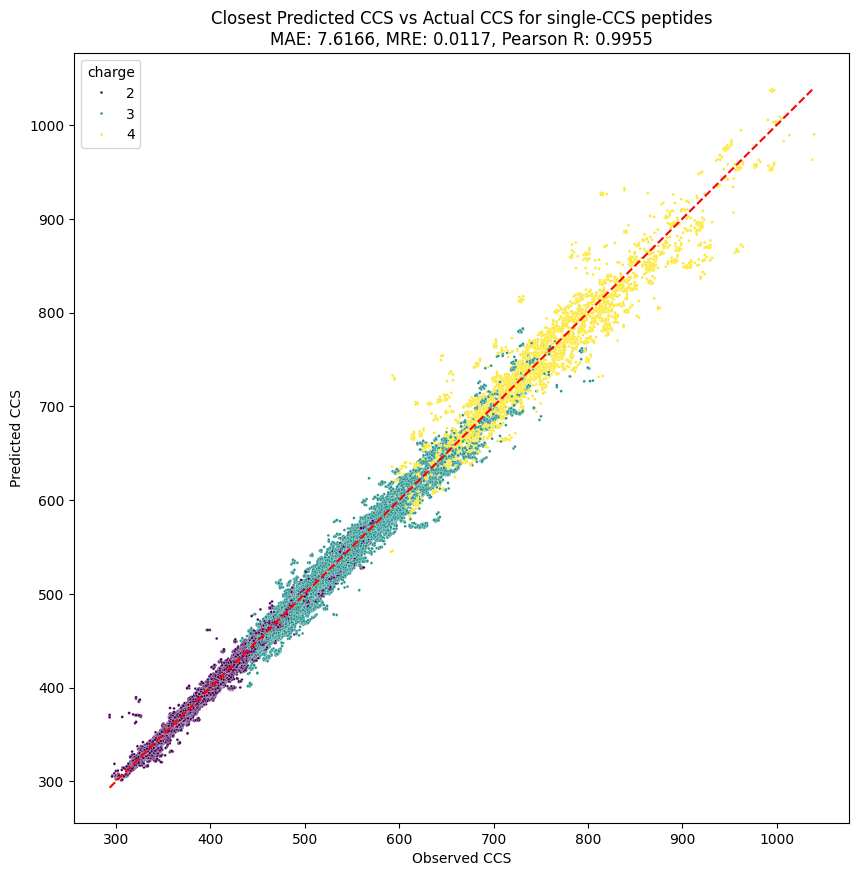

In [176]:
# Plot prediction accuracy
mae = abs(ccs_df_aligned['CCS'] - ccs_df_aligned['Closest predicted CCS']).mean()
mre = (abs(ccs_df_aligned['CCS'] - ccs_df_aligned['Closest predicted CCS']) / ccs_df_aligned['CCS']).median()
pearsonr = ccs_df_aligned['CCS'].corr(ccs_df_aligned['Closest predicted CCS'])
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=ccs_df_aligned, x='CCS', y='Closest predicted CCS', s=4, hue='charge', palette='viridis', ax=ax)
ax.plot([min(ccs_df_aligned['CCS']), max(ccs_df_aligned['CCS'])], [min(ccs_df_aligned['CCS']), max(ccs_df_aligned['CCS'])], color='red', linestyle='--')
ax.set_xlabel('Observed CCS')
ax.set_ylabel('Predicted CCS')
ax.set_title(f'Closest Predicted CCS vs Actual CCS for single-CCS peptides\nMAE: {mae:.4f}, MRE: {mre:.4f}, Pearson R: {pearsonr:.4f}')
plt.show()

# Predict with one-output model


In [187]:
traindata_full_model = pd.read_csv('/home/robbe/DeepLCCS/datasets/final/MeierWillJonas.csv')
eval_with_overlap_converted = pd.read_csv('/home/robbe/IM2DeepMulti/Evaluation_dataset_v2_with_overlap.csv')

In [194]:
traindata_full_model.rename(columns={'tr': 'CCS'}, inplace=True)

In [179]:
BASEMODELCONFIG = {
        "AtomComp_kernel_size": 4,
        "DiatomComp_kernel_size": 4,
        "One_hot_kernel_size": 4,
        "AtomComp_out_channels_start": 356,
        "DiatomComp_out_channels_start": 65,
        "Global_units": 20,
        "OneHot_out_channels": 1,
        "Concat_units": 94,
        "AtomComp_MaxPool_kernel_size": 2,
        "DiatomComp_MaxPool_kernel_size": 2,
        "OneHot_MaxPool_kernel_size": 10,
        "LRelu_negative_slope": 0.013545684190756122,
        "LRelu_saturation": 40,
        }

In [180]:
from IM2DeepMulti.models import IM2Deep
unimodal_model = IM2Deep(BASEMODELCONFIG)
unimodal_model.load_state_dict(torch.load('/home/robbe/IM2DeepMulti/BestParams_final_model_state_dict.pth'))
unimodal_model.to(torch.device('cuda'))
unimodal_model.eval()
with torch.no_grad():
    predictions = []
    for batch in dataloader:
        atom_enc, diatom_enc, global_enc, one_hot, y = batch
        prediction = unimodal_model(atom_enc, diatom_enc, global_enc, one_hot)
        predictions.append(prediction)
    predictions = torch.cat(predictions, dim=0)

1335
480
20
6
1841


In [181]:
ccs_df['Unimodal Predicted CCS'] = predictions.cpu().numpy()

In [190]:
eval_with_overlap_converted

,Unnamed: 0,Modified sequence,Intensity,charge,m/z,Retention time,Raw file,Experiment,1/K0,CCS,between_brackets,seq,modifications,tr
0,0,(ac)AAAAAAAAAAGAAGGR,58830.0,2,620.823275,28.682,7_S1-B2_1_7050,B3,1.033297,418.47580,Acetyl (Protein N-term,AAAAAAAAAAGAAGGR,0|Acetyl,0
1,1,(ac)AAAAAAAAAAGAAGGR,51048.0,2,620.823275,28.545,8_S1-B4_1_7052,B4,1.033297,418.47577,Acetyl (Protein N-term,AAAAAAAAAAGAAGGR,0|Acetyl,0
2,2,(ac)AAAAAAAAAAGDSDSWDADTFSMEDPVRK,33143.0,3,970.766403,37.406,7_S1-B2_1_7050,B3,1.123101,677.93670,Acetyl (Protein N-term,AAAAAAAAAAGDSDSWDADTFSMEDPVRK,0|Acetyl,0
3,3,(ac)AAAAAAGAASGLPGPVAQGLK,176510.0,2,895.991600,34.106,10_S1-B8_1_7056,C2,1.248190,503.78998,Acetyl (Protein N-term,AAAAAAGAASGLPGPVAQGLK,0|Acetyl,0
4,4,(ac)AAAAAAGAASGLPGPVAQGLK,73423.0,2,895.991600,34.024,11_S1-B10_1_7058,C3,1.245645,502.76257,Acetyl (Protein N-term,AAAAAAGAASGLPGPVAQGLK,0|Acetyl,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146624,146624,YYVTIIDAPGHRDFIK,28209.0,3,636.671988,25.584,3_S1-A6_1_7042,A3,0.904345,547.25200,NaN,YYVTIIDAPGHRDFIK,Not modified,0
146625,146625,YYVTIIDAPGHRDFIK,22666.0,3,636.671988,25.702,4_S1-A8_1_7044,A4,0.904345,547.25200,NaN,YYVTIIDAPGHRDFIK,Not modified,0
146626,146626,YYVTIIDAPGHRDFIK,29843.0,3,636.671988,25.646,5_S1-A10_1_7046,B1,0.904345,547.25200,NaN,YYVTIIDAPGHRDFIK,Not modified,0
146627,146627,YYVTIIDAPGHRDFIK,58577.0,3,636.671988,25.706,6_S1-A12_1_7048,B2,0.904345,547.25200,NaN,YYVTIIDAPGHRDFIK,Not modified,0


In [196]:
def align(Evaluation_dataset_with_overlap, traindata, ccs_df):
    for i, run in enumerate(Evaluation_dataset_with_overlap['Raw file'].unique()):
        shift_dict = {}
        data_run = Evaluation_dataset_with_overlap[Evaluation_dataset_with_overlap['Raw file'] == run]

        try:
            merged = pd.merge(data_run, traindata, on=['seq', 'modifications', 'charge'], how='inner', suffixes=('_data', '_train'))
            shift_dict = merged.groupby('charge').apply(lambda x: x['CCS_train'].mean() - x['CCS_data'].mean()).to_dict() #How much train data is bigger, so we need to decrease the predictions by these amounts
            print('Shifts for run', run, shift_dict)
            for charge, shift in shift_dict.items():
                ccs_df.loc[(ccs_df['Raw file'] == run) & (ccs_df['charge'] == charge), 'Unimodal Predicted CCS'] -= shift
        except Exception as e:
            print('No overlap found for run', run, e)
            continue
    return ccs_df


In [197]:
ccs_df_aligned = align(eval_with_overlap_converted, traindata_full_model, ccs_df)

Shifts for run 7_S1-B2_1_7050 {2: -9.76179566563627, 3: -13.375992058674342, 4: -10.237257779538936}
Shifts for run 8_S1-B4_1_7052 {2: -9.784585560797382, 3: -13.425371691966916, 4: -10.450980002998108}
Shifts for run 10_S1-B8_1_7056 {2: -11.138726746862233, 3: -15.422325557255135, 4: -12.924539453754164}
Shifts for run 11_S1-B10_1_7058 {2: -8.994398359868796, 3: -12.424661361644667, 4: -5.350422646622519}
Shifts for run 13_S1-C2_1_7062 {2: -9.259062828485185, 3: -12.729568519746294, 4: -7.745507143664668}
Shifts for run 14_S1-C4_1_7064 {2: -9.05539336262251, 3: -12.714783586596809, 4: -7.116222101344533}
Shifts for run 15_S1-C6_1_7066 {2: -8.478613875591861, 3: -11.80397878072165, 4: -7.311398965654007}
Shifts for run 16_S1-C8_1_7068 {2: -9.283430801437305, 3: -13.041031701006204, 4: -8.672563959147055}
Shifts for run 1_S1-A2_1_7038 {2: -8.870878347386906, 3: -13.291286126018576, 4: -8.087106131513792}
Shifts for run 2_S1-A4_1_7040 {2: -10.19127874051702, 3: -14.525812220443981, 4: -1

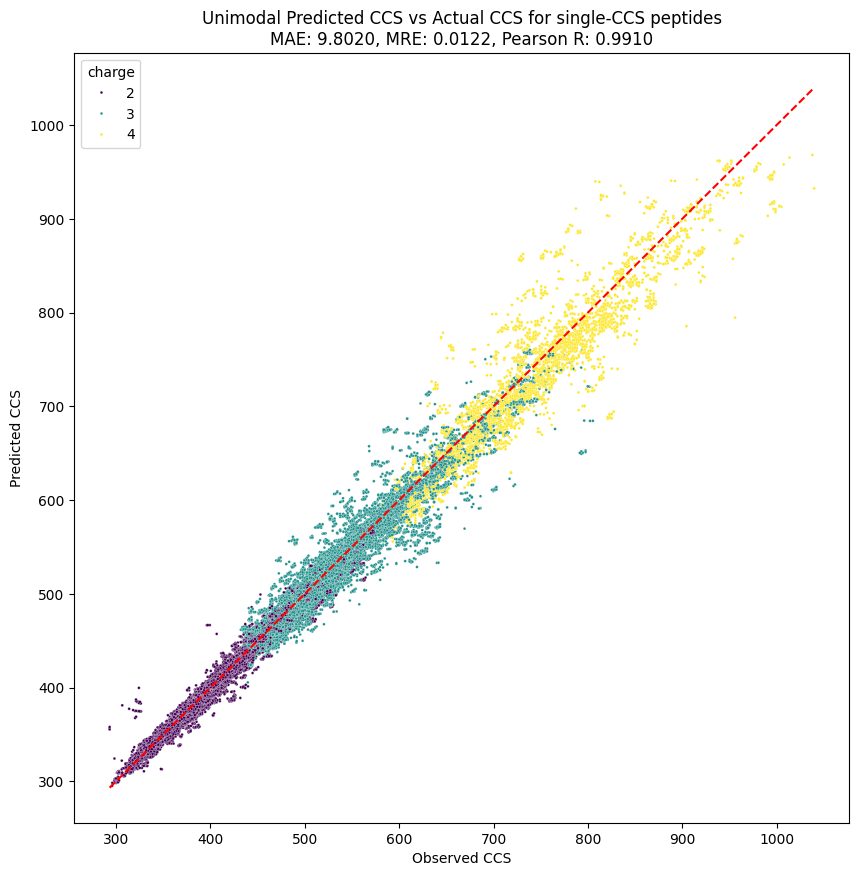

In [198]:
# Plot prediction accuracy
mae = abs(ccs_df_aligned['CCS'] - ccs_df_aligned['Unimodal Predicted CCS']).mean()
mre = (abs(ccs_df_aligned['CCS'] - ccs_df_aligned['Unimodal Predicted CCS']) / ccs_df_aligned['CCS']).median()
pearsonr = ccs_df_aligned['CCS'].corr(ccs_df_aligned['Unimodal Predicted CCS'])
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=ccs_df_aligned, x='CCS', y='Unimodal Predicted CCS', s=4, hue='charge', palette='viridis', ax=ax)
ax.plot([min(ccs_df_aligned['CCS']), max(ccs_df_aligned['CCS'])], [min(ccs_df_aligned['CCS']), max(ccs_df_aligned['CCS'])], color='red', linestyle='--')
ax.set_xlabel('Observed CCS')
ax.set_ylabel('Predicted CCS')
ax.set_title(f'Unimodal Predicted CCS vs Actual CCS for single-CCS peptides\nMAE: {mae:.4f}, MRE: {mre:.4f}, Pearson R: {pearsonr:.4f}')
plt.show()

In [199]:
# Save the aligned predictions per run to a csv file
for run in ccs_df_aligned['Raw file'].unique():
    run_data = ccs_df_aligned[ccs_df_aligned['Raw file'] == run]
    # Remove duplicates modified sequence - charge states
    run_data = run_data.drop_duplicates(subset=['Modified sequence', 'charge'])
    run_data.to_csv(f'/home/robbe/IM2DeepMulti/dataset/Evaluations_v2/{run}_predictions.csv', index=False)